# My very own Linear Regression Class/Methods to do some common tasks

This notebook details my attempts to create a customized class for Linear Regression that adds some functionality to do some tasks which are frequently performed in a regression workflow:

* Computing residuals
* Diagnostic plots
* Reporting all model evaluation metrics ($R^2$, MAE, RMSE)
* Matching coefficients to feature (column) names
* Plotting coefficients ordered by magnitude

Please note that all work here is for demo purposes and modeling is not at all the emphasis.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
plt.style.use('fivethirtyeight')

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from sklearn.datasets import load_boston
boston = load_boston()

So, we're going to use the well-known [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) in this notebook, even though the modeling is not really all that important. Let's start off by seeing what happens using scikit-learn. The target, I assume, is what is denoted as the variable `MEDV` elsewhere.

In [4]:
bos = pd.DataFrame(boston.data)
bos.columns = boston.feature_names

In [5]:
bos['PRICE'] = boston.target

In [6]:
X = bos.drop('PRICE', axis = 1)
y = bos['PRICE']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
lr = LinearRegression()
lr.fit(X_train, y_train)
feat_names = X.columns.tolist() + ['Intercept']
coefs = lr.coef_.tolist() + [lr.intercept_]
coef_df = pd.DataFrame(zip(feat_names, coefs), columns=['Feature', 'Coef'])

In [8]:
coef_df

,Feature,Coef
0,CRIM,-0.112463
1,ZN,0.030081
2,INDUS,0.040731
3,CHAS,2.786767
4,NOX,-17.240635
5,RM,4.432488
6,AGE,-0.006240
7,DIS,-1.448485
8,RAD,0.262114
9,TAX,-0.010639


In [9]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.7508837786732915, 0.6684825753971597)

In [10]:
y_prd = lr.predict(X_train)
print('Mean absolute error: ' , mean_absolute_error(y_train, y_prd))
print('Root mean squared error: ', np.sqrt(mean_squared_error(y_train, y_prd)))

Mean absolute error:  3.315164531222009
Root mean squared error:  4.652050526021356


In [11]:
y_pred = lr.predict(X_test)
print('Mean absolute error: ' , mean_absolute_error(y_test, y_pred))
print('Root mean squared error: ', np.sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error:  3.191508972274815
Root mean squared error:  4.9306619159797815


OK, now that we've seen the results using scikit-learn, let's put together a Linear Regression class of our own and see how it compares. And perhaps dig a little deeper in what everything above means (it seems a "reasonable" fit without much indication of over/underfitting but again, this is not our focus).

The only class variable here is `fit_intercept` (whether we have a model with an intercept), which is True by default. I'm using the [normal equation](http://mlwiki.org/index.php/Normal_Equation) in the `fit` method, so the types of problems this class might be pretty limited.

In [12]:
class Linear_Regression():
    def __init__(self, fit_intercept=True):
        # constructor, either fit w/ intercept or not
        self.fit_intercept = fit_intercept
        
    def fit(self, X, y):
        # X (feature matrix) and y (target vector)
        
        # if fitting w/ intercept, add column of ones at end of X
        if self.fit_intercept:
            X = np.concatenate([X, np.ones([len(X), 1])], axis=1)
            
        # fit (get feature weights) using normal eqn    
        b = np.dot(np.linalg.inv(np.dot(X.T, X)), np.dot(X.T, y))
        
        # assign (as attributes) the feature coefficients and intercept
        self.coefs = b[:-1]
        self.intercept = b[-1]
        
    def predict(self, X):
        # for X, compute predictions using results from fit
        return np.dot(X, self.coefs) + self.intercept if self.fit_intercept else np.dot(X, self.coefs)
    
    def residuals(self, X, y):
        # for X, y, compute difference between actual and predicted target values
        return y-self.predict(X)
    
    def plot_diagnostics(self, X, y):
        # for X, y, create diagnostic plots for fit using residuals and predictions
        
        res = self.residuals(X,y)
        pred = self.predict(X)
        
        # initialize grid of diagnostic plots
        fig, ax = plt.subplots(2, 2, figsize=(16, 12))
        plt.subplots_adjust(hspace=0.4)
        
        # Residual Histogram
        ax[0,0].hist(res)
        ax[0,0].set_title('Histogram of Residuals')
        ax[0,0].set_xlabel('Residuals')
        ax[0,0].set_ylabel('Relative Frequency')
        ax[0,0].set_xlim(-np.max(abs(res)), np.max(abs(res)))
        
        # Residuals vs Predictions
        ax[0,1].scatter(pred, res)
        ax[0,1].set_title('Residuals vs Fitted')
        ax[0,1].set_xlabel('Fitted Values')
        ax[0,1].set_ylabel('Residuals')
        
        # Residual Q-Q plot
        sm.qqplot(res, ax = ax[1,0], line='s')
        ax[1,0].set_title('Normal Q-Q')
        
        # Residuals vs Index
        ax[1,1].scatter(res.index, res)
        ax[1,1].set_title('Residuals vs Index')
        ax[1,1].set_xlabel('Index')
        ax[1,1].set_ylabel('Residuals')
        
    def score(self, X, y):
        # for X, y compute and print all metrics (R^2, RMSE<, MAE)
        res = self.residuals(X,y)
        print('Coefficient of Determination (R^2): ', 1 - (np.sum(res**2) / np.sum((y-np.mean(y))**2)))
        print('Root Mean Squared Error (RMSE): ', np.sqrt(np.mean(res**2))) 
        print('Mean Absolute Error (MAE): ', np.mean(abs(res)))
    
    def formatted_coefs(self, X, sort=False):
        # for X, match feature names to estimated coefficients and sort (by absolute value) if you want to sort
        coef_df = pd.DataFrame(zip(X.columns, self.coefs), columns=['Feature Name', 'Coefficient'])
        return pd.DataFrame(sorted(coef_df.values, key=lambda t: abs(t[1]), reverse=True), columns=coef_df.columns)\
            .set_index('Feature Name') if sort else coef_df
    
    def plot_sorted_coefs(self, X):
        # for X, plot the sorted coefficients
        coef_sorted = self.formatted_coefs(X, sort=True)
        fig, ax = plt.subplots(figsize=(8,6))
        coef_sorted.plot.barh(ax=ax).invert_yaxis()
        ax.set_title('Model Coefficents by Importance')
        ax.legend([])

OK, now let's see how well this works!

In [13]:
lr2 = Linear_Regression()

In [14]:
lr2.fit(X_train, y_train)

In [15]:
lr2.coefs

array([-1.12463481e-01,  3.00810168e-02,  4.07309919e-02,  2.78676719e+00,
       -1.72406347e+01,  4.43248784e+00, -6.23998173e-03, -1.44848504e+00,
        2.62113793e-01, -1.06390978e-02, -9.16398679e-01,  1.24516469e-02,
       -5.09349120e-01])

In [16]:
lr2.intercept

30.288948339380113

Intercept is the same as what we get from scikit-learn but I can't just match up everything in that array of coefs that easily! Let's make it look "nicer":

In [17]:
coef_df2 = lr2.formatted_coefs(X_train)

In [18]:
coef_df2

,Feature Name,Coefficient
0,CRIM,-0.112463
1,ZN,0.030081
2,INDUS,0.040731
3,CHAS,2.786767
4,NOX,-17.240635
5,RM,4.432488
6,AGE,-0.006240
7,DIS,-1.448485
8,RAD,0.262114
9,TAX,-0.010639


It matches up! Now let's order them by magnitude:

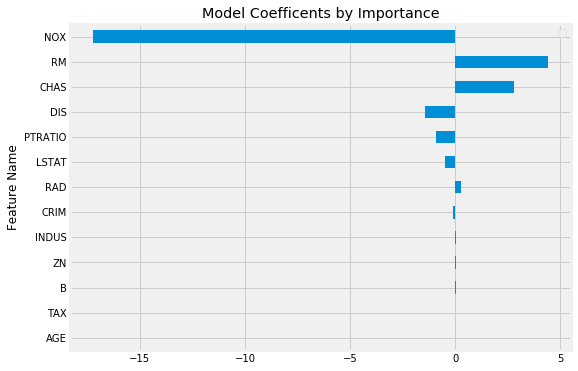

In [19]:
lr2.plot_sorted_coefs(X_train)

Let's take a look at some diagnostics now. Hmmm, looks not quite adequate for a linear model? Might make sense since we are predicting housing prices that we might need to [log-transform](https://people.duke.edu/~rnau/regex3.htm) the target here.

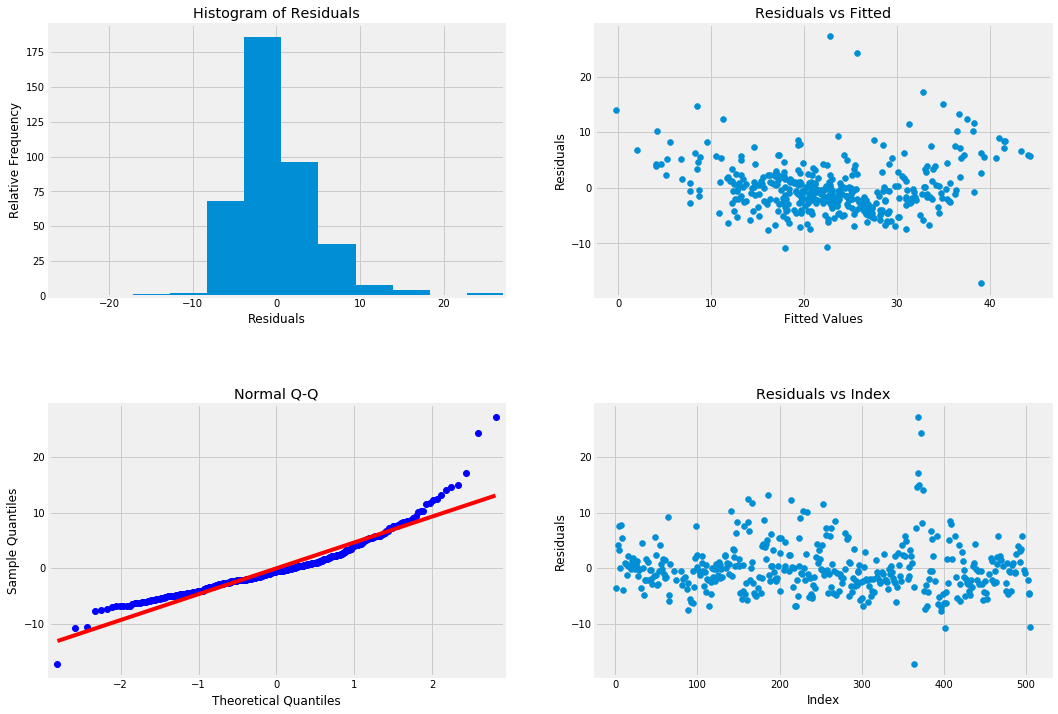

In [20]:
lr2.plot_diagnostics(X_train,y_train)

Well, even though the data might need to be transformed to be accommodated by a linear model, let's evaluate it anyway and see how it compares to the fit from scikit-learn:

In [21]:
lr2.score(X_train, y_train)

Coefficient of Determination (R^2):  0.7508837786732915
Root Mean Squared Error (RMSE):  4.652050526021356
Mean Absolute Error (MAE):  3.315164531221959


In [23]:
lr2.score(X_test, y_test)

Coefficient of Determination (R^2):  0.6684825753970853
Root Mean Squared Error (RMSE):  4.930661915980333
Mean Absolute Error (MAE):  3.191508972275598


Not bad!

Some other functionality I could add here:

* The diagnostic plots could be modified to look something like the diagnostic plots you can produce [using R](https://data.library.virginia.edu/diagnostic-plots/).
* Diagnostic tests, like you see in [statsmodels output](https://www.statsmodels.org/devel/examples/notebooks/generated/regression_diagnostics.html).
* Add a method for [Ridge or Lasso](http://math.bu.edu/people/cgineste/classes/ma575/p/w14_1.pdf).
* Add a method for [standardized residuals](http://www.r-tutor.com/elementary-statistics/simple-linear-regression/standardized-residual).

From a design standpoint for the class, perhaps residuals could be an attribute, like `coefs` and `intercept`?